# Keyphrase Extraction using Word2Vec with Spectral Clustering

## 1. Importing Libraries

In [1]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import nltk,re, pprint
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import stopwords
from nltk.chunk.regexp import tag_pattern2re_pattern 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import state_union

## 2. Text Processing 
        This Step includes removing the stop words , tokenize the text to convert into sentences and converting each word into lower case.

In [2]:
# Set Parameters
n_clusters = 100    # No. Of Clusters
stop_words = set(stopwords.words('english'))
Actual_Summary = "output.txt"

def text_processing(file):
    f = open(file, 'r', encoding='utf-8')
    text = f.read()
    
    
    
    #Tokenization : Convert to sentences and then to words
    sentences = nltk.sent_tokenize(text)
    
    data = []
    for sent in sentences:
        words = nltk.word_tokenize(sent)
        words = [w.lower() for w in words if len(w)>2 and w not in stop_words]
        words = [w.lower() for w in words if w != "the"]
        data.append(words)
        
    return data

text = text_processing("input.txt")
print("Text Processing : done")

print(text)

count_frequency = {}
for line in text:
    for w in line:
        count_frequency[w] = 0
        
for line in text:
    for w in line:
        count_frequency[w] = count_frequency[w] + 1
            
candidate_term = len(count_frequency.keys())

print(candidate_term)

Text Processing : done
[['movie', 'body', 'hits', 'peer-to-peer', 'nets', 'movie', 'industry', 'struck', 'file-sharing', 'networks', 'another', 'round', 'lawsuits'], ['motion', 'picture', 'association', 'america', 'mpaa', 'also', 'said', 'succeeded', 'getting', 'network', 'called', 'lokitorrent', 'closed'], ['latest', 'network', 'uses', 'peer-to-peer', 'system', 'called', 'bittorrent', 'hit', 'mpaa'], ['mpaa', 'began', 'legal', 'campaign', 'operators', 'similar', 'networks', 'across', 'four', 'continents', 'december'], ['dallas', 'court', 'agreed', 'hollywood', 'lawyers', 'would', 'allowed', 'access', 'lokitorrent', 'server', 'records', 'could', 'let', 'single', 'sharing', 'files', 'illegally'], ['october', '2004', 'site', 'provided', 'links', '30,000', 'files'], ['action', 'came', 'operators', 'lokitorrent', 'agreed', 'settlement', 'mpaa'], ['stark', 'message', 'appeared', 'site', 'mpaa', 'warning', 'you', 'click', "n't", 'hide'], ['bittorrent', 'systems', 'server', 'sites', 'host', '

## 3. Word2Vec Model 

In [3]:
from gensim.models import Word2Vec

model = Word2Vec(text, size=300, window = 10, min_count=1)
words = list(model.wv.vocab)
print(len(words))

print("Word2Vec Model : done")

151
Word2Vec Model : done


/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


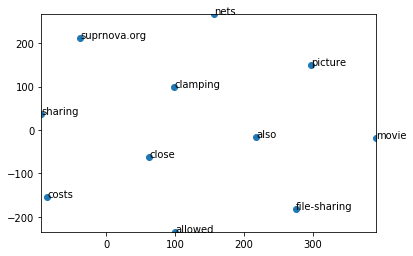

In [5]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
display_closestwords_tsnescatterplot(model, words[0])

## 4. Spectral Clustering Applied

/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


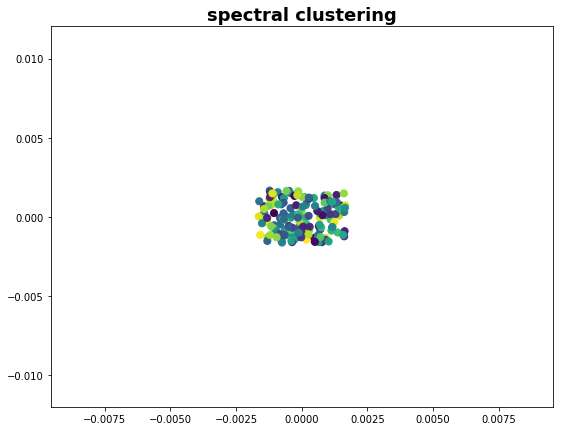

In [6]:
# Implement Spectral Clustering

from sklearn.cluster import SpectralClustering
dot_size=50
cmap = 'viridis'

n_clusters = int(candidate_term*4/5)
model_spectral = SpectralClustering(n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')

labels = model_spectral.fit_predict(model.wv.syn0)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('spectral clustering', fontsize=18, fontweight='demi')
plt.scatter(model.wv.syn0[:, 0], model.wv.syn0[:, 1], c=labels, s=dot_size, cmap=cmap)


## 5. Applied K-Means and Regular Expression Parser

In [7]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np

y_hc = []       
y_hc = labels.copy()              # Output Of Spectral Clustering : A list 
summary = []

print(len(y_hc))
print("***************************************************************************************************")

# Extracting The Keyword by choosing the mean of cluster
def Extracted_Keywords(clus, clus_name):
    
    kmeans = KMeans(n_clusters=1, random_state=0).fit(clus)
    labels = kmeans.labels_
    mean = kmeans.cluster_centers_.reshape(300,1)
    min_to_centre = []
    
    for i in clus:
        Y = distance.cdist(i.reshape(300,1), mean, 'euclidean')
        sum_Y = np.sum(Y)
        min_to_centre.append(sum_Y)

    min_value = min(min_to_centre)
    ind_value = np.argmin(min_to_centre)
    
#     print(ind_value)
#     print(clus_name[ind_value])  
    summary.append(clus_name[ind_value])
    
    
    
for j in range(0,n_clusters):
    clus = []
    clus_name = []
    count = 0
    for i in range(len(y_hc)):
        if(y_hc[i] == j):
            count += 1
            clus.append(model[words[i]])
            clus_name.append(words[i])
    
    Extracted_Keywords(clus, clus_name)
    
  

print("done")


151
***************************************************************************************************


/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


done


In [8]:
import collections
summary_frequency = {}

for word in summary:
    summary_frequency[word] = count_frequency[word]
    
od = sorted(summary_frequency.items(), key=lambda x: x[1])
od = od[::-1]

print(od)
result = []

for i in range(0,20):
    result.append(od[i][0])

    
    
# Regular Expression Parser
grammar = "chunk:{(<JJ>)*(<NN | NNS | NNP>)+} " 
chunkParser= RegexpParser(grammar)
tagged = nltk.pos_tag(result)
result = chunkParser.parse(tagged)
for subtree in result.subtrees():
    print(subtree)
result.draw()


[('mpaa', 6), ('bittorrent', 5), ('operators', 5), ('called', 3), ('host', 3), ('server', 3), ('lokitorrent', 3), ('networks', 3), ('file-sharers', 2), ('lawsuits', 2), ('sites', 2), ('illegally', 2), ('said', 2), ('movie', 2), ('industry', 2), ('agreed', 2), ('servers', 2), ('links', 2), ('systems', 2), ('peer-to-peer', 2), ('others', 2), ('across', 2), ('site', 2), ('network', 2), ('file-sharing', 2), ('dallas', 1), ('another', 1), ('illegal', 1), ('closed', 1), ('programmes', 1), ('forced', 1), ('30,000', 1), ('number', 1), ('material', 1), ('filing', 1), ('link', 1), ('copyrighted', 1), ('phoenix', 1), ('well', 1), ('settlement', 1), ('trackers', 1), ('uses', 1), ('popular', 1), ('copyright', 1), ('came', 1), ('access', 1), ('100', 1), ('infringe', 1), ('costs', 1), ('struck', 1), ('hits', 1), ('body', 1), ('laws', 1), ('click', 1), ('since', 1), ('content', 1), ('association', 1), ('strategy', 1), ('take', 1), ('claimed', 1), ('motion', 1), ('hitting', 1), ('copied', 1), ('they', 

In [9]:
right_lis=[]
def getNodes(parent):
    print(parent.label())
    for node in parent:
      
        if type(node) is nltk.Tree:
            if node.label() == 'chunk':
                print("hii")
                #print(node.leaves())
                right_lis.append(node.leaves())
                #print("Sentence:", " ".join(node.leaves()))  
                
            
            else:
                print(node.label())
        else:
            pass
        print(node)  
        
getNodes(result)
print("done")


S
hii
(chunk mpaa/JJ bittorrent/NN operators/NNS)
('called', 'VBD')
hii
(chunk host/NN server/NN)
hii
(chunk
  lokitorrent/JJ
  networks/NNS
  file-sharers/NNS
  lawsuits/NNS
  sites/NNS)
('illegally', 'RB')
('said', 'VBD')
hii
(chunk movie/NN industry/NN)
('agreed', 'VBD')
hii
(chunk servers/NNS links/NNS systems/NNS peer-to-peer/NN)
done


In [10]:

keyphrase=[]
str1=''
for i in range(len(right_lis)):
    for j in range(len(right_lis[i])):
        for k in range(len(right_lis[i][j])-1):
            if right_lis[i][j][k+1] != 'JJ':
             
                str1=str1+right_lis[i][j][k]
                keyphrase.append(str1)
                str1=''
            else:
            
                str1=str1+right_lis[i][j][k] + ' '
    str1=' '
#print(right_lis)
print("Keyphrases : ",keyphrase)

Keyphrases :  ['mpaa bittorrent', 'operators', ' host', 'server', ' lokitorrent networks', 'file-sharers', 'lawsuits', 'sites', ' movie', 'industry', ' servers', 'links', 'systems', 'peer-to-peer']


## 6. Results : Precision, Recall, F-Measure

In [11]:
from rouge import Rouge 

def Calculate_Score():
    str2 = ""
    for i in summary:
        str2 = str2 + i
        str2 = str2 + " "
    
    print("Predicted Summary : \n")
    print(str2)

    print("\n\n")
    
    
    f = open(Actual_Summary, 'r', encoding='utf-8')
    text = f.read()
    
    print("Actual Summary : \n")
    print(text)

    rouge = Rouge()
    scores = rouge.get_scores(text, str2)
    print("\n\n")
    
    print("F-Measure : ", scores[0]['rouge-1']['f'])
    print("Precision : ", scores[0]['rouge-1']['p'])
    print("Recall    : ", scores[0]['rouge-1']['r'])
    
Calculate_Score()

Predicted Summary : 

people you similar soon like sharing 2004 message file-sharing began single allowed given billions swap unspecified network online site dvds videos america stunt direct latest stark filed suprnova.org october hide hit lawyers court worried followed using across others let peer-to-peer run films every systems links succeeded close networks targeting records lokitorrent could servers also year would system nets continents operators n't aggressively campaign provided clamping agreed picture high-profile suits they copied hitting motion server claimed bittorrent take strategy association content since click laws body hits mpaa struck costs host infringe 100 access came copyright popular uses trackers settlement well phoenix copyrighted link filing industry material number 30,000 forced movie programmes closed said illegally sites illegal another lawsuits file-sharers called dallas 



Actual Summary : 

It has filed 100 lawsuits against operators of BitTorrent server 